In [31]:
import os, cv2
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as album
import segmentation_models_pytorch as smp

경로 수정

In [32]:
DATA_DIR = r"C:\Users\swu\Desktop\augmented"
train_dir=os.path.join(DATA_DIR,'train')
test_dir=os.path.join(DATA_DIR,'test')

x_train_dir = os.path.join(DATA_DIR, 'train/image')
y_train_dir = os.path.join(DATA_DIR, 'train/label')

x_valid_dir = os.path.join(DATA_DIR, 'val/image')
y_valid_dir = os.path.join(DATA_DIR, 'val/label')

x_test_dir = os.path.join(DATA_DIR, 'test/image')
y_test_dir = os.path.join(DATA_DIR, 'test/label')

class & RGB 수정

- type1: single_jersey / 청록 (0, 255, 255)
- type2: rib / 빨강 (255, 0, 0)
- type3: purl / 초록 (0, 255, 0)
- type4: interlock 파랑 -> 삭제
- type5: moss / 핑크 (255, 20, 147)
- type6: ajour / 노랑 (255, 255,0)
- background / 검정 (0,0,0)

In [33]:
# Useful to shortlist specific classes in datasets with large number of classes
# select_classes = ['type1'- single, 'type2'- rib, 'type3'- purl, 'type4' - interlock, 'type5' - moss, 'type6' - ajour, 'background']
select_classes = ['type1', 'type2', 'type3', 'type5', 'type6', 'background'] # single, rib, purl

# Get RGB values of required classes
# select_class_rgb_values =  [[255,255,0]- single, [0,0,255] - rib, [0,255,0] - purl, [255,0,0] - interlock, [147,20,255] - moss, [0,255,255] - ajour, [0,0,0] - background]
select_class_rgb_values =  [[0,255,255], [255,0,0], [0,255,0], [255,20,147], [255,255,0], [0,0,0]] # single, rib, purl

In [34]:
# helper function for data visualization

def visualize(**images):
    """
    Plot images in one row
    """
    n_images = len(images) #픽셀 수
    plt.figure(figsize=(20,8))

    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([])
        plt.yticks([])
        # get title from the parameter names
        plt.title(name.replace('_',' ').title(), fontsize=20)
        if name=="ground_truth_mask":
          plt.imshow(image, cmap='tab10')
        else:
          plt.imshow(image)
    plt.show()

# Perform one hot encoding on label

def one_hot_encode(label, label_values):
    #픽셀 단위로 one-hot encoding??
    label=label.astype(int)
    semantic_map = []

    for colour in label_values[:-1]:
      # 현재 색상과 일치 여부를 확인 -> 픽셀 깨짐에 대비하기 위해 distance 계산으로 변경함함
      distance = np.linalg.norm(label - colour, axis=-1)  # (H, W)
      # 기준색상과의 픽셀 차이<=30이면 같은 type으로 판별
      class_map = distance <= 30 
      semantic_map.append(class_map) #각 select_classes 마다 해당되는 픽셀 정보 저장


    # 라벨링되지 않은 영역 판별
    labeled_area = np.any(semantic_map, axis=0)  # 라벨링된 영역 
    unlabeled_area = ~labeled_area  # 라벨링되지 않은 영역 

    # Semantic map 업데이트
    semantic_map.append(unlabeled_area)  # 배경 (unlabeled_area)을 추가
    semantic_map = np.stack(semantic_map, axis=-1)  # (H, W, num_classes+1)

    return semantic_map

# Perform reverse one-hot-encoding on labels / preds
def reverse_one_hot(image):
    # x = np.argmax(image, axis = -1)
    y=[]
    for i in range(len(image)):
      x=np.argmax(image[i], axis =1)
      y.append(x)
      # if i==0:
      #   x=np.expand_dims(x, axis=0)
    return y

# Perform colour coding on the reverse-one-hot outputs
def colour_code_segmentation(image, label_values):
    colour_codes = np.array(label_values)
    x = colour_codes[image]

    return x

class BuildingsDataset(torch.utils.data.Dataset):
    def __init__(
            self,
            images_dir,
            masks_dir,
            class_rgb_values=None,
            augmentation=None,
            augmentation_img=None,
            preprocessing=None,
    ):

        self.image_paths = [os.path.join(images_dir, image_id) for image_id in sorted(os.listdir(images_dir))]
        self.mask_paths = [os.path.join(masks_dir, mask_id) for mask_id in sorted(os.listdir(masks_dir))]

        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.augmentation_img = augmentation_img
        self.preprocessing = preprocessing

    def __getitem__(self, i):

        # read images and masks-RGB로 변환
        image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2RGB)

        # one-hot-encode the mask
        mask = one_hot_encode(mask, self.class_rgb_values).astype('float')

        # apply augmentations
        # augentation : image, mask에 모두 적용
        # augmentation_img : image에만 적용(ex.색 관련 augmentation) 
        if self.augmentation:
            sample1 = self.augmentation(image=image, mask=mask)
            image, mask = sample1['image'], sample1['mask']
            if self.augmentation_img:
                sample2 = self.augmentation_img(image=image, mask=mask)
                image = sample2['image']
        elif self.augmentation_img:
            sample2 = self.augmentation_img(image=image, mask=mask)
            image = sample2['image']

        # apply preprocessing(적용되지 않고 있음)
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

    def __len__(self):
        # return length of
        return len(self.image_paths)
    

#
def get_training_augmentation():
    train_transform = [
        album.Resize(height=256, width=256, always_apply=True),
        album.OneOf(
            [
                album.HorizontalFlip(p=1),
                album.VerticalFlip(p=1),
                album.RandomRotate90(p=1),
            ],
            p=0.75, #augmentation이 적용될 확률
        ),
    ]
    return album.Compose(train_transform)

#
def get_training_color_augmentation():
    train_transform2 = [
        album.OneOf(
            [
                album.CLAHE(clip_limit=(1, 5))
                ],
            p=1,
        ),
    ]
    return album.Compose(train_transform2)

def get_validation_augmentation():
    # Add sufficient padding to ensure image is divisible by 32
    test_transform = [
        album.Resize(height=256, width=256, always_apply=True),
    ]
    return album.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

def get_preprocessing(preprocessing_fn=None):
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))

    return album.Compose(_transform)


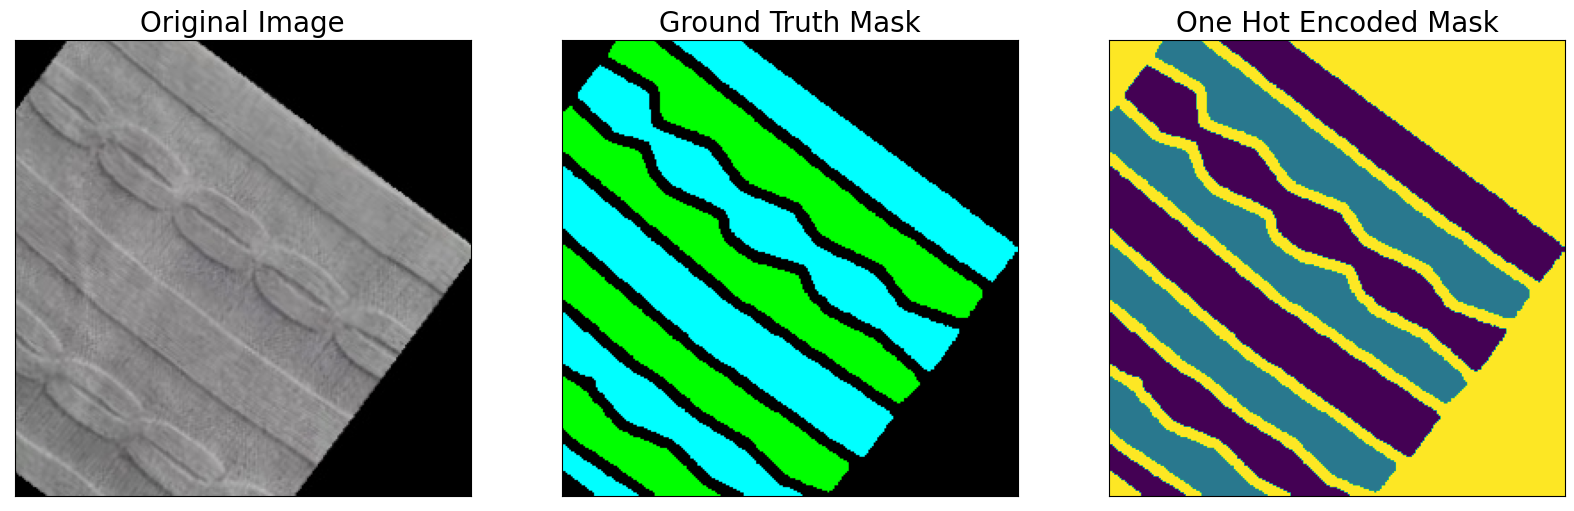

256


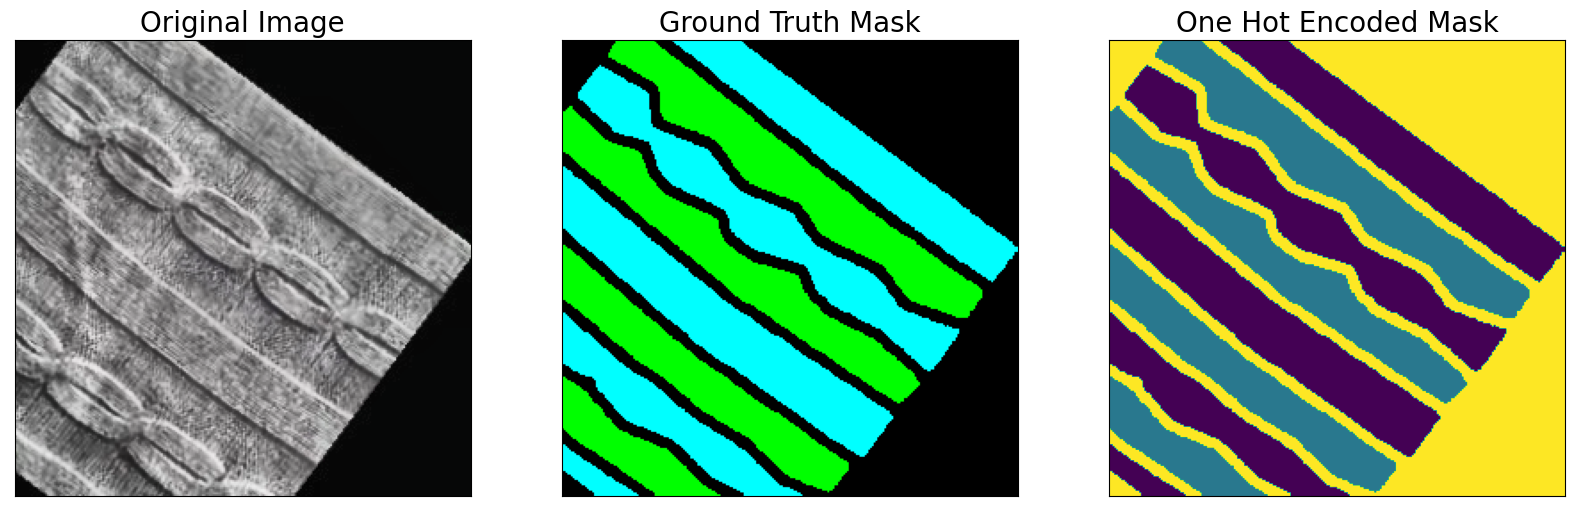

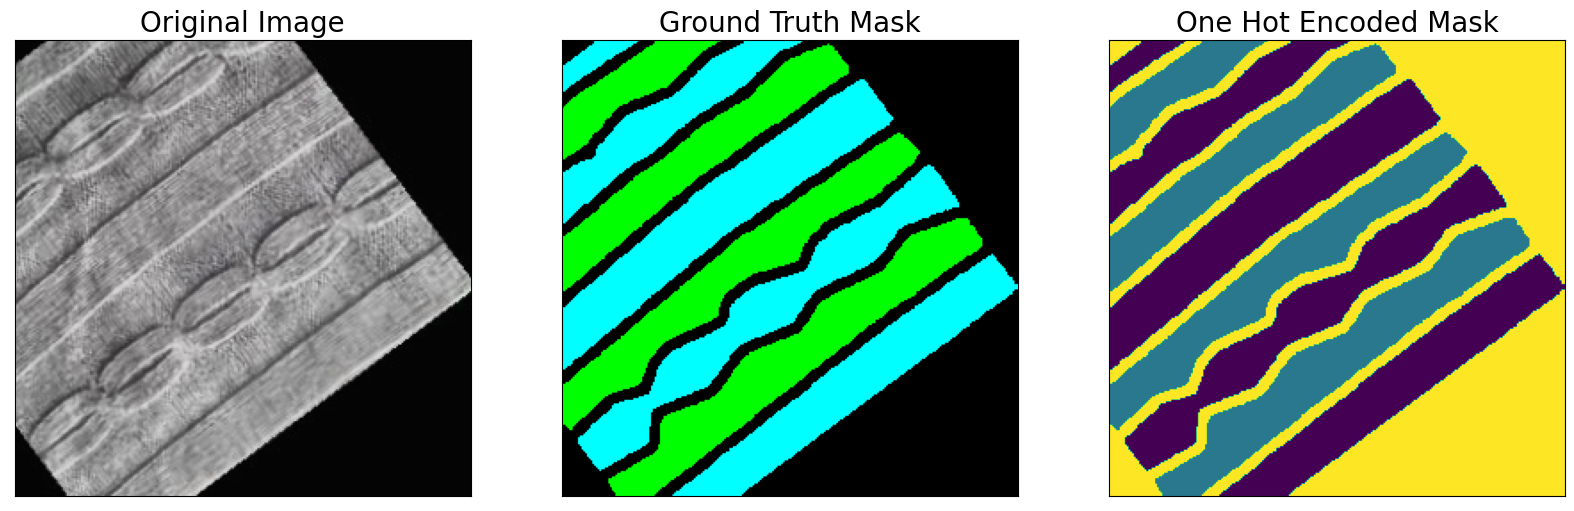

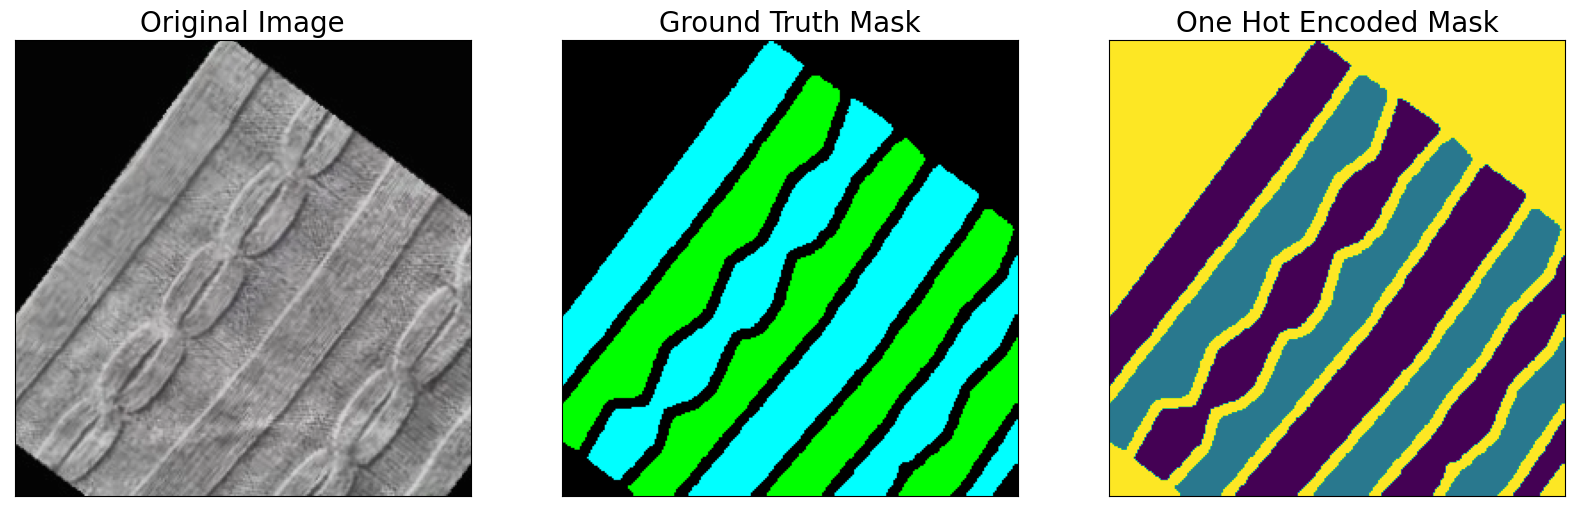

In [35]:
# class_values=[0,1,2,3,4,5,6]
dataset = BuildingsDataset(x_train_dir, y_train_dir, class_rgb_values=select_class_rgb_values)
random_idx = random.randint(0, len(dataset)-1)
image, mask = dataset[1]
ground_truth_mask=[]
for i in range(len(image)):
  ground_truth_mask.append(colour_code_segmentation(reverse_one_hot(mask)[i], select_class_rgb_values))
visualize(
  original_image = image,
  ground_truth_mask=ground_truth_mask,
  # ground_truth_mask=colour_code_segmentation(reverse_one_hot(mask), class_values),
  one_hot_encoded_mask = reverse_one_hot(mask)
)
print(len(ground_truth_mask))

augmented_dataset = BuildingsDataset(
    x_train_dir, y_train_dir,
    augmentation=get_training_augmentation(), ###
    augmentation_img=get_training_color_augmentation(),
    class_rgb_values=select_class_rgb_values
)

random_idx = random.randint(0, len(augmented_dataset)-1)

# Different augmentations on a random image/mask pair (256*256 crop)
for i in range(3):
    image, mask = augmented_dataset[1]
    visualize(
        original_image = image,
        ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
        one_hot_encoded_mask = reverse_one_hot(mask)
    )

In [36]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_val_loss = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):
        # Check if validation loss is nan
        if np.isnan(val_loss):
            self.trace_func("Validation loss is NaN. Ignoring this epoch.")
            return

        if self.best_val_loss is None:
            self.best_val_loss = val_loss
            self.save_checkpoint(val_loss, model)
        elif val_loss < self.best_val_loss - self.delta:
            # Significant improvement detected
            self.best_val_loss = val_loss
            self.save_checkpoint(val_loss, model)
            self.counter = 0  # Reset counter since improvement occurred
        else:
            # No significant improvement
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decreases.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

CLASSES 수정

- type1: single_jersey
- type2: rib
- type3: purl
- type4: interlock
- type5: moss 
- type6: ajour 
- background

In [37]:
ENCODER = 'resnet101'
ENCODER_WEIGHTS = 'imagenet'
# CLASSES = ['type1', 'type2', 'type3', 'type4', 'type5', 'type6', 'background']
CLASSES = ['type1','type2','type3','type5','type6','background']
ACTIVATION = 'softmax2d' # could be None for logits or 'softmax2d' for multiclass segmentation

# create segmentation model with pretrained encoder
model = smp.DeepLabV3Plus(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES),
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

train_dataset = BuildingsDataset(
    x_train_dir, y_train_dir,
    augmentation=get_training_augmentation(),
    augmentation_img=get_training_color_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)
valid_dataset = BuildingsDataset(
    x_valid_dir, y_valid_dir,
    augmentation=get_training_augmentation(),
    # augmentation_img=get_training_color_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

# Get train and val data loaders
if __name__ == "__main__":
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
    valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False, num_workers=0)



에포크 설정

In [38]:
import math
from torch.optim.lr_scheduler import _LRScheduler

class CosineAnnealingWarmUpRestarts(_LRScheduler):
    def __init__(self, optimizer, T_0, T_mult=1, eta_max=0.1, T_up=0, gamma=1., last_epoch=-1):
        if T_0 <= 0 or not isinstance(T_0, int):
            raise ValueError("Expected positive integer T_0, but got {}".format(T_0))
        if T_mult < 1 or not isinstance(T_mult, int):
            raise ValueError("Expected integer T_mult >= 1, but got {}".format(T_mult))
        if T_up < 0 or not isinstance(T_up, int):
            raise ValueError("Expected positive integer T_up, but got {}".format(T_up))
        self.T_0 = T_0
        self.T_mult = T_mult
        self.base_eta_max = eta_max
        self.eta_max = eta_max
        self.T_up = T_up
        self.T_i = T_0
        self.gamma = gamma
        self.cycle = 0
        self.T_cur = last_epoch
        super(CosineAnnealingWarmUpRestarts, self).__init__(optimizer, last_epoch)
    
    def get_lr(self):
        if self.T_cur == -1:
            return self.base_lrs
        elif self.T_cur < self.T_up:
            return [(self.eta_max - base_lr)*self.T_cur / self.T_up + base_lr for base_lr in self.base_lrs]
        else:
            return [base_lr + (self.eta_max - base_lr) * (1 + math.cos(math.pi * (self.T_cur-self.T_up) / (self.T_i - self.T_up))) / 2
                    for base_lr in self.base_lrs]

    def step(self, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
            self.T_cur = self.T_cur + 1
            if self.T_cur >= self.T_i:
                self.cycle += 1
                self.T_cur = self.T_cur - self.T_i
                self.T_i = (self.T_i - self.T_up) * self.T_mult + self.T_up
        else:
            if epoch >= self.T_0:
                if self.T_mult == 1:
                    self.T_cur = epoch % self.T_0
                    self.cycle = epoch // self.T_0
                else:
                    n = int(math.log((epoch / self.T_0 * (self.T_mult - 1) + 1), self.T_mult))
                    self.cycle = n
                    self.T_cur = epoch - self.T_0 * (self.T_mult ** n - 1) / (self.T_mult - 1)
                    self.T_i = self.T_0 * self.T_mult ** (n)
            else:
                self.T_i = self.T_0
                self.T_cur = epoch
                
        self.eta_max = self.base_eta_max * (self.gamma**self.cycle)
        self.last_epoch = math.floor(epoch)
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr

# Define Tversky Loss
class TverskyLoss(nn.Module):
    def __init__(self, alpha=0.5, beta=0.5, smooth=1e-6):
        super(TverskyLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.smooth = smooth

    def forward(self, y_pred, y_true):
        y_pred = torch.sigmoid(y_pred)
        y_true = y_true.float()
        tp = torch.sum(y_true * y_pred)
        fp = torch.sum((1 - y_true) * y_pred)
        fn = torch.sum(y_true * (1 - y_pred))
        tversky_index = (tp + self.smooth) / (tp + self.alpha * fp + self.beta * fn + self.smooth)
        return 1 - tversky_index
    
from segmentation_models_pytorch import utils
import tensorflow as tf

# Set flag to train the model or not. If set to 'False', only prediction is performed (using an older model checkpoint)
TRAINING = True

# Set num of epochs
EPOCHS = 15

# Set device: `cuda` or `cpu`
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define loss function
# loss = smp.utils.losses.DiceLoss()
# loss = TverskyLoss(alpha=0.5, beta=0.5)  # Tversky loss
# loss = nn.CrossEntropyLoss()  # CrossEntropy loss for multi-class
# loss=tf.keras.losses.categorical_crossentropy()
loss=smp.losses.FocalLoss(mode='binary')
loss.__name__='focal_loss'
# loss.__name__='crossentropy_loss'

# define metrics
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
    smp.utils.metrics.Accuracy(threshold=0.5),
    smp.utils.metrics.Fscore(threshold=0.5),
    smp.utils.metrics.Precision(threshold=0.5),
    smp.utils.metrics.Recall(threshold=0.5)
]
test_metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
    smp.utils.metrics.Accuracy(threshold=0.5),
    smp.utils.metrics.Fscore(threshold=0.5),
    smp.utils.metrics.Precision(threshold=0.5),
    smp.utils.metrics.Recall(threshold=0.5)
]
# define optimizer
optimizer = torch.optim.Adam([
    dict(params=model.parameters(), lr=0.0001, weight_decay=2e-5),
])

lr_scheduler = CosineAnnealingWarmUpRestarts(optimizer, T_0=10, T_mult=1, eta_max=0.01,  T_up=2, gamma=0.2)

# # load best saved model checkpoint from previous commit (if present)
# if os.path.exists('../input/deeplabv3-efficientnetb4-frontend-using-pytorch/best_model.pth'):
#     model = torch.load('../input/deeplabv3-efficientnetb4-frontend-using-pytorch/best_model.pth', map_location=DEVICE)
early_stopping = EarlyStopping(patience=7, verbose=True)


In [39]:
train_epoch = smp.utils.train.TrainEpoch(
    model,
    loss=loss,
    metrics=metrics,
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

In [40]:
%%time

if TRAINING:
    model.train()
    best_iou_score = 0.0
    train_logs_list, valid_logs_list = [], []

    for i in range(0, EPOCHS):

        # Perform training & validation
        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(valid_loader)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)
        
        # Save model if a better val IoU score is obtained
        if best_iou_score < valid_logs['iou_score']:
            best_iou_score = valid_logs['iou_score']
            torch.save(model, './best_model.pth')
            print('Model saved!')
        if i>20:
            focal_loss=valid_logs['focal_loss']
            early_stopping(focal_loss, model)
            if early_stopping.early_stop:
                print("Epoch:{} Early stopping triggered".format(i))
                break


Epoch: 0
valid: 100%|██████████| 23/23 [00:02<00:00, 10.34it/s, focal_loss - 0.1833, iou_score - 0.4923, accuracy - 0.8973, fscore - 0.6529, precision - 0.7388, recall - 0.5992]
Model saved!

Epoch: 1
valid: 100%|██████████| 23/23 [00:02<00:00, 10.27it/s, focal_loss - 0.1859, iou_score - 0.4726, accuracy - 0.8844, fscore - 0.6372, precision - 0.6689, recall - 0.6107]

Epoch: 2
valid: 100%|██████████| 23/23 [00:02<00:00,  9.74it/s, focal_loss - 0.1837, iou_score - 0.5026, accuracy - 0.8895, fscore - 0.6571, precision - 0.6749, recall - 0.6413]
Model saved!

Epoch: 3
valid: 100%|██████████| 23/23 [00:02<00:00, 10.69it/s, focal_loss - 0.1841, iou_score - 0.4877, accuracy - 0.8867, fscore - 0.6458, precision - 0.6664, recall - 0.6282]

Epoch: 4
valid: 100%|██████████| 23/23 [00:01<00:00, 11.77it/s, focal_loss - 0.1855, iou_score - 0.4805, accuracy - 0.8845, fscore - 0.639, precision - 0.6617, recall - 0.6201] 

Epoch: 5
valid: 100%|██████████| 23/23 [00:01<00:00, 11.75it/s, focal_loss - 0

In [41]:
# load best saved model checkpoint from the current run
if os.path.exists('./best_model.pth'):
    best_model = torch.load('./best_model.pth', map_location=DEVICE)
    print('Loaded DeepLabV3+ model from this run.')
    torch.save(best_model,"./DeepLabV3_best_model.pth")

# load best saved model checkpoint from previous commit (if present)
# elif os.path.exists('./DeepLabV3_best_model.pth'):
#     best_model = torch.load('./DeepLabV3_best_model.pth', map_location=DEVICE)
#     print('Loaded DeepLabV3+ model from a previous commit.')

# create test dataloader (with preprocessing operation: to_tensor(...))
test_dataset = BuildingsDataset(
    x_test_dir,
    y_test_dir,
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

test_dataloader = DataLoader(test_dataset)

# test dataset for visualization (without preprocessing transformations)
test_dataset_vis = BuildingsDataset(
    x_test_dir, y_test_dir,
    augmentation=get_training_augmentation(),
    class_rgb_values=select_class_rgb_values,
)

# get a random test image/mask index
random_idx = random.randint(0, len(test_dataset_vis)-1)
image, mask = test_dataset_vis[random_idx]

# visualize(
#     original_image = image,
#     ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
#     one_hot_encoded_mask = reverse_one_hot(mask)
# )
# print(random_idx)

# Center crop padded image / mask to original image dims
def crop_image(image, target_image_dims=[256,256,3]):

    target_size = target_image_dims[0]
    image_size = len(image)
    padding = (image_size - target_size) // 2

    return image[
        padding:image_size - padding,
        padding:image_size - padding,
        :,
    ]

sample_preds_folder = 'sample_predictions/'
if not os.path.exists(sample_preds_folder):
    os.makedirs(sample_preds_folder)

Loaded DeepLabV3+ model from this run.


pred_building_heatmap type 수정

In [ ]:
import sys
for idx in range(len(test_dataset)):

    image, gt_mask = test_dataset[idx]
    # image_vis = crop_image(test_dataset_vis[idx][0].astype('uint8'))
    # image_vis = (test_dataset_vis[idx][0].astype('uint8'))
    # image_vis = (image * 255)
    image_vis = np.transpose(image, (1, 2, 0))
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    # Predict test image
    pred_mask = best_model(x_tensor)
    pred_mask = pred_mask.detach().squeeze().cpu().numpy()
    # Convert pred_mask from `CHW` format to `HWC` format
    pred_mask = np.transpose(pred_mask,(1,2,0))
    # Get prediction channel corresponding to building

    ## heatmap 수정

    pred_building_heatmap = pred_mask[:,:,select_classes.index('type2')]
    # pred_mask = crop_image(colour_code_segmentation(reverse_one_hot(pred_mask), select_class_rgb_values))
    pred_mask = (colour_code_segmentation(reverse_one_hot(pred_mask), select_class_rgb_values))

    # Convert gt_mask from `CHW` format to `HWC` format
    gt_mask = np.transpose(gt_mask,(1,2,0))
    # gt_mask = crop_image(colour_code_segmentation(reverse_one_hot(gt_mask), select_class_rgb_values))
    gt_mask = (colour_code_segmentation(reverse_one_hot(gt_mask), select_class_rgb_values))
    # cv2.imwrite(os.path.join(sample_preds_folder, f"sample_pred_{idx}.png"), np.hstack([image_vis, gt_mask, pred_mask])[:,:,::-1])

    visualize(
        original_image = image_vis,
        ground_truth_mask = gt_mask,
        predicted_mask = pred_mask,
        predicted_building_heatmap = pred_building_heatmap
    )

In [43]:
test_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=test_metrics,
    device=DEVICE,
    verbose=True,
)

valid_logs = test_epoch.run(test_dataloader)
print("Evaluation on Test Data: ")
print(f"Mean IoU Score: {valid_logs['iou_score']:.4f}")
print(f"Mean Dice Loss: {valid_logs['focal_loss']:.4f}")

print(valid_logs)

valid: 100%|██████████| 230/230 [00:07<00:00, 28.75it/s, focal_loss - 0.1825, iou_score - 0.5152, accuracy - 0.8919, fscore - 0.665, precision - 0.6902, recall - 0.6431] 
Evaluation on Test Data: 
Mean IoU Score: 0.5152
Mean Dice Loss: 0.1825
{'focal_loss': 0.182521850777709, 'iou_score': 0.5151616614473903, 'accuracy': 0.8919090452401531, 'fscore': 0.664995605207008, 'precision': 0.6901625503664433, 'recall': 0.6431238589079485}


In [44]:
train_logs_df = pd.DataFrame(train_logs_list)
valid_logs_df = pd.DataFrame(valid_logs_list)
valid_logs_df.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
focal_loss,0.183256,0.185901,0.183746,0.184117,0.185459,0.187298,0.183689,0.185186,0.179119,0.181589,0.180894,0.179091,0.182887,0.177803,0.179092
iou_score,0.492296,0.472600,0.502623,0.487726,0.480489,0.463392,0.507450,0.483533,0.549043,0.528839,0.533879,0.556401,0.507880,0.566741,0.552059
accuracy,0.897301,0.884418,0.889547,0.886680,0.884453,0.877953,0.889611,0.884040,0.903522,0.896530,0.898547,0.902942,0.891103,0.906745,0.903220
fscore,0.652939,0.637244,0.657092,0.645830,0.638964,0.625530,0.661262,0.644436,0.703358,0.682332,0.689337,0.703440,0.666649,0.714715,0.703040
precision,0.738797,0.668929,0.674858,0.666396,0.661712,0.637046,0.672523,0.656041,0.717572,0.695879,0.702416,0.714944,0.678316,0.725460,0.715983
recall,0.599155,0.610666,0.641294,0.628195,0.620105,0.615048,0.650876,0.633795,0.690243,0.670200,0.677168,0.692679,0.655877,0.704607,0.690892


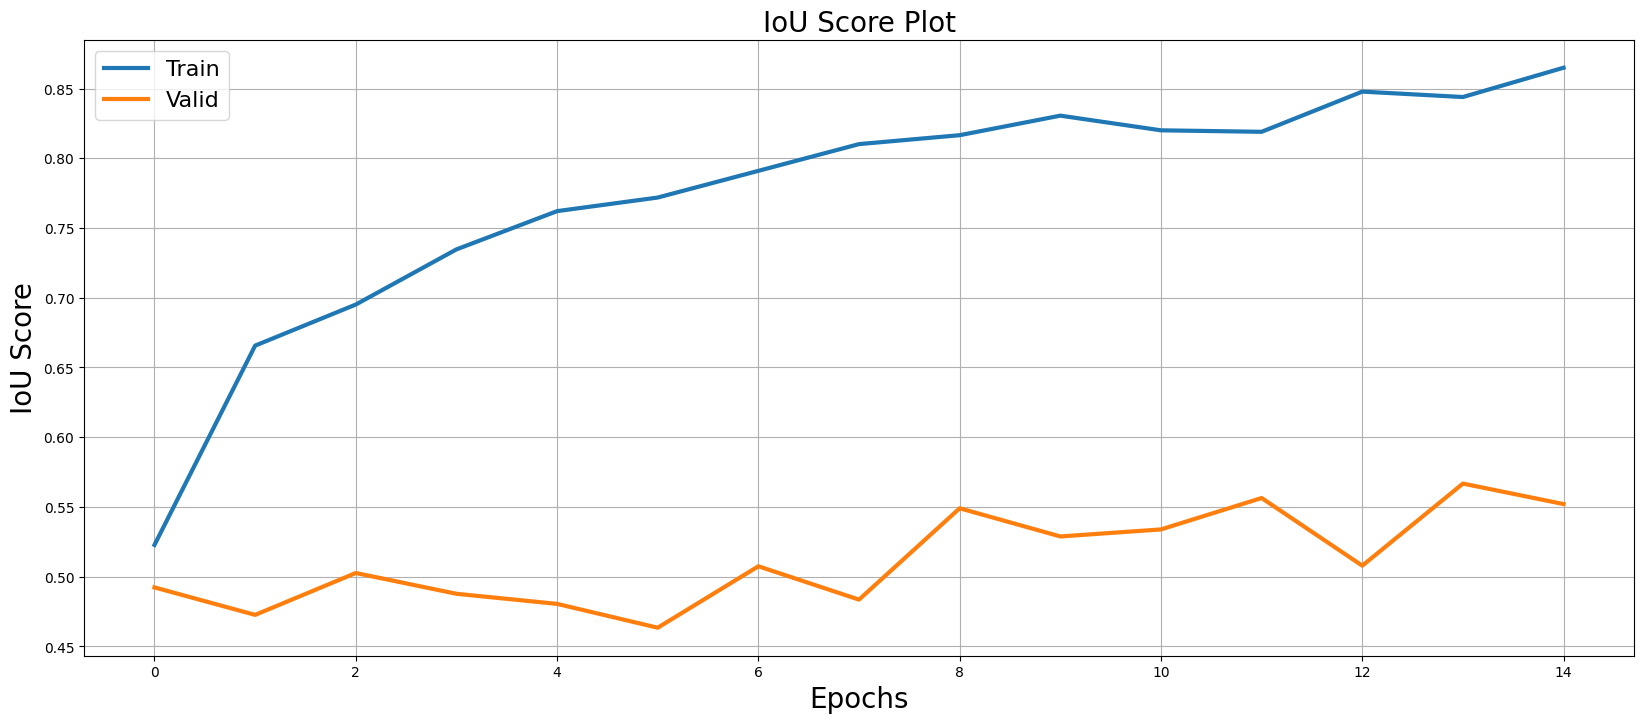

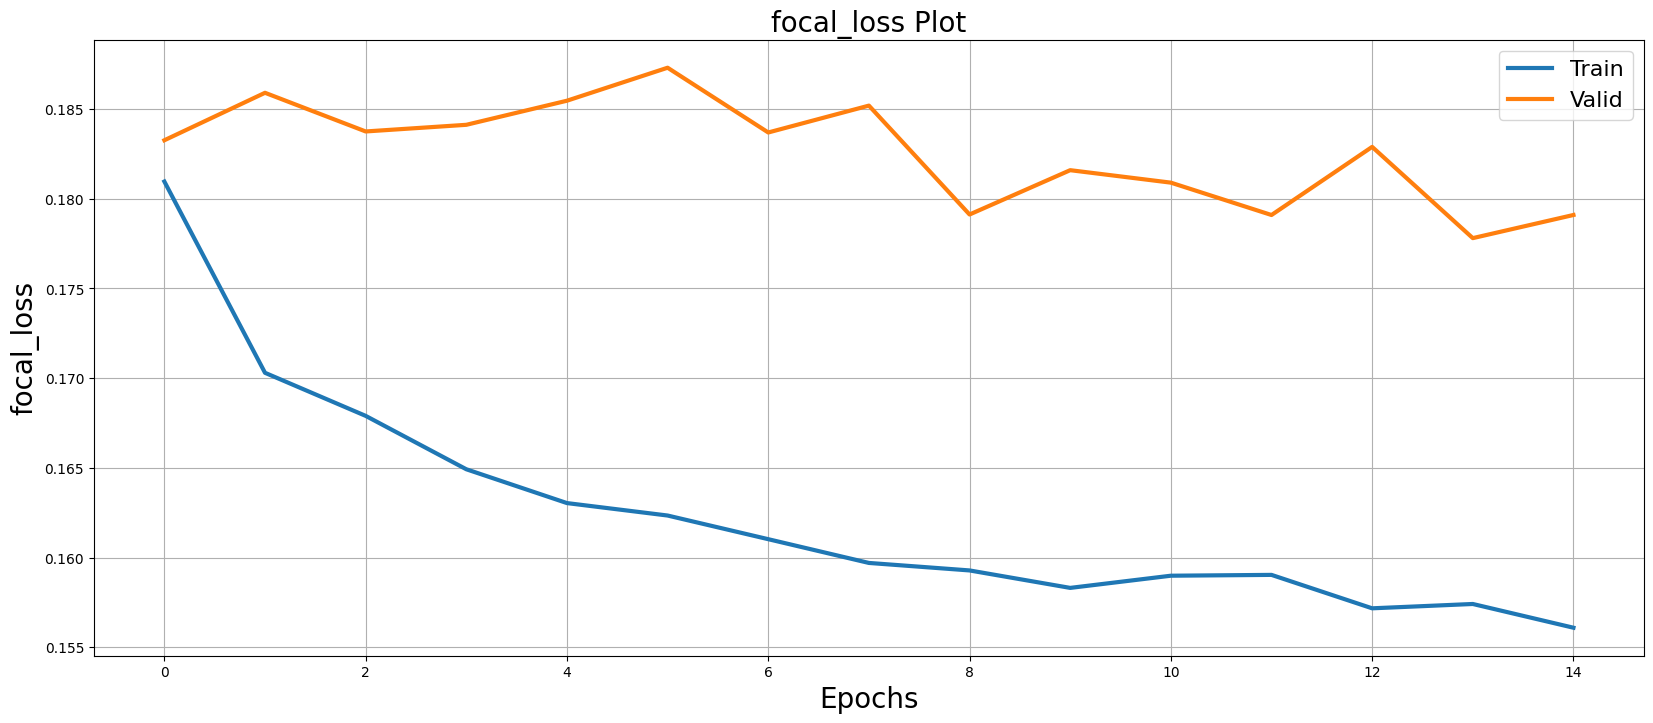

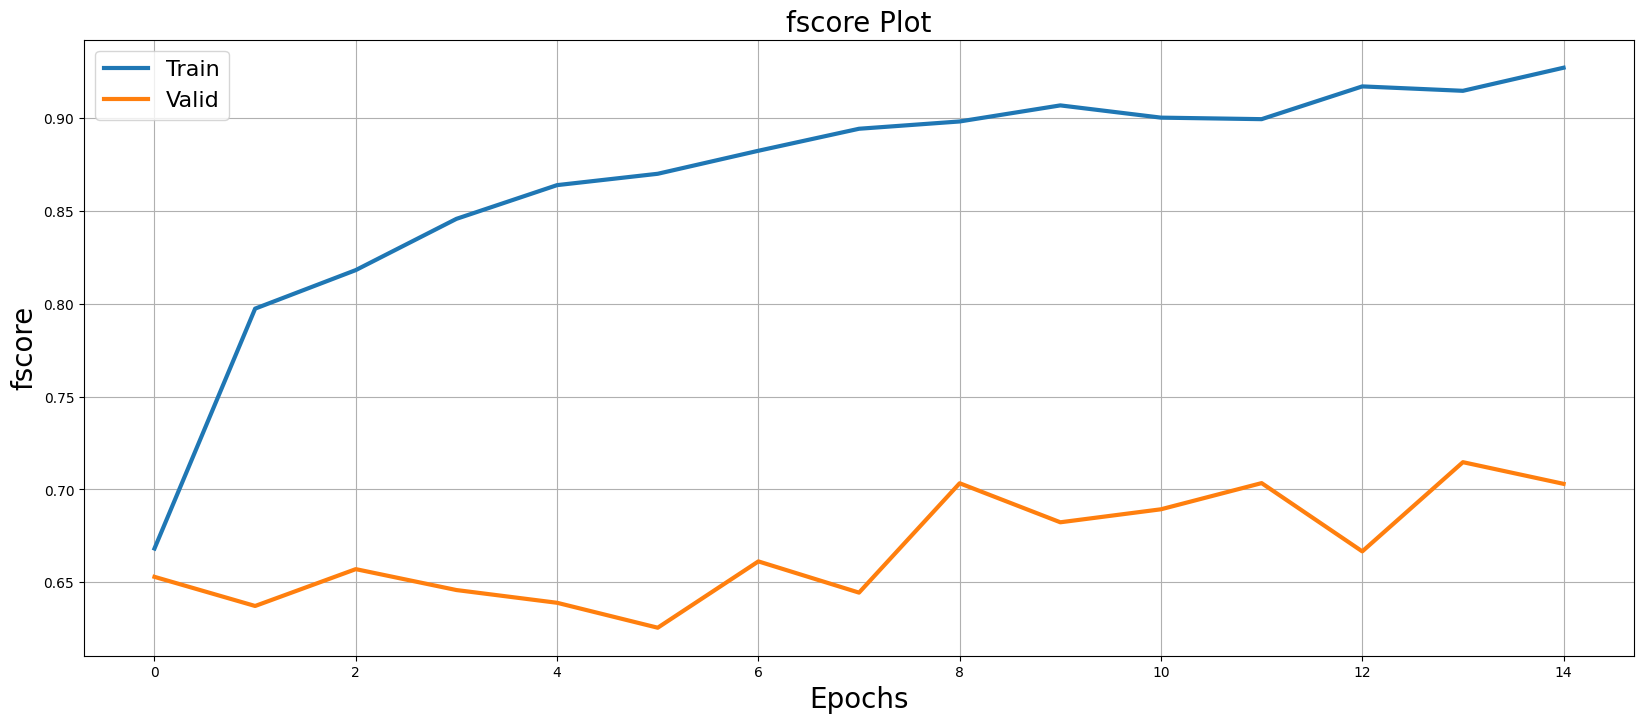

In [45]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.iou_score.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.iou_score.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('IoU Score', fontsize=20)
plt.title('IoU Score Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('iou_score_plot.png')
plt.show()

plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.focal_loss.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.focal_loss.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('focal_loss', fontsize=20)
plt.title('focal_loss Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig('dice_loss_plot.png')
plt.show()

plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.fscore.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.fscore.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('fscore', fontsize=20)
plt.title('fscore Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
# plt.savefig('dice_loss_plot.png')
plt.show()